### Using time-series modelling to predict covid community weekly-infection-ratio in Singapore

In this project, we will be applying ARIMA, ARIMAX and neural networks to model the time-series data.

The following steps are executed to 
- Extract data from https://covidsitrep.moh.gov.sg/_dash-layout
- The community, dormitory and imported weekly cases and weekly-ratio
- Check for stationary of dataset
- Fit data to model
- Tune parameters of model
- Visualize actual and predicted data

In [159]:
# Import libraries
import requests
import pandas as pd
import time
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2, l1
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy import stats
import pickle

In [160]:
# Import JSON data from covidsitrep MOH website
API_path = 'https://covidsitrep.moh.gov.sg/_dash-layout'
MOH = requests.get(API_path).json()

In [161]:
# Extract relevant data from JSON data
# 0 & 1 - Community Cases
# 2 & 3 - Dorm Cases
# 4 & 5 - Imported Cases
date_1 = MOH['props']['children'][1]['props']['children'][2]['props']['children'][0]['props']['figure']['data'][0]['x']
date_2 = MOH['props']['children'][1]['props']['children'][2]['props']['children'][0]['props']['figure']['data'][1]['x']
comm_cases_1 = MOH['props']['children'][1]['props']['children'][2]['props']['children'][0]['props']['figure']['data'][0]['y']
comm_cases_2 = MOH['props']['children'][1]['props']['children'][2]['props']['children'][0]['props']['figure']['data'][1]['y']
dorm_cases_1 = MOH['props']['children'][1]['props']['children'][2]['props']['children'][0]['props']['figure']['data'][2]['y']
dorm_cases_2 = MOH['props']['children'][1]['props']['children'][2]['props']['children'][0]['props']['figure']['data'][3]['y']
import_cases_1 = MOH['props']['children'][1]['props']['children'][2]['props']['children'][0]['props']['figure']['data'][4]['y']
import_cases_2 = MOH['props']['children'][1]['props']['children'][2]['props']['children'][0]['props']['figure']['data'][5]['y']

In [162]:
# Format the data into a pandas dataframe
d = {"date": date_1+date_2, "comm_cases": comm_cases_1+comm_cases_2, 
     "dorm_cases": dorm_cases_1+dorm_cases_2,"import_cases": import_cases_1+import_cases_2}
df = pd.DataFrame(data=d)
train_dates = pd.to_datetime(df['date'])

In [163]:
# Check if any null values are present and the data types of the data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718 entries, 0 to 717
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          718 non-null    object 
 1   comm_cases    718 non-null    float64
 2   dorm_cases    718 non-null    float64
 3   import_cases  718 non-null    float64
dtypes: float64(3), object(1)
memory usage: 22.6+ KB


In [164]:
# Function to generate the total covid cases in a week
def weekly_cases(select, column_name):
    weekly_cases = [0, 0, 0, 0, 0, 0]
    for x in range(6, len(select)):
        weekly_avg = (select.loc[x, column_name]+
                     select.loc[x-1, column_name]+
                     select.loc[x-2, column_name]+
                     select.loc[x-3, column_name]+
                     select.loc[x-4, column_name]+
                     select.loc[x-5, column_name]+
                     select.loc[x-6, column_name])
        weekly_cases.append(weekly_avg)
    return weekly_cases

In [165]:
# Function to generate the week-to-week infection ratio. See link below for details.
# (https://www.todayonline.com/singapore/explainer-what-weekly-infection-growth-rate-and-how-does-it-help-us-assess-covid-19)
def weekly_ratio(select, column_name):
    weekly_ratio = [0.0]*13
    for x in range(13, len(select)):
        if select.loc[x-7, column_name] == 0:
            weekly_ratio.append(weekly_ratio[-1])
        else:
            avg_ratio = (select.loc[x, column_name])/select.loc[x-7, column_name]
            weekly_ratio.append(avg_ratio)
    return weekly_ratio

In [166]:
# Generate weekly cases and week-to-week infection ratio
df["comm_weekly_cases"] = weekly_cases(df, "comm_cases")
df["comm_weekly_ratio"] = weekly_ratio(df, "comm_weekly_cases")
df["dorm_weekly_cases"] = weekly_cases(df, "dorm_cases")
df["dorm_weekly_ratio"] = weekly_ratio(df, "dorm_weekly_cases")
df["import_weekly_cases"] = weekly_cases(df, "import_cases")
df["import_weekly_ratio"] = weekly_ratio(df, "import_weekly_cases")

In [167]:
# Remove daily cases as daily cases are highly volatile and not stable for predicting
df.drop(columns=["comm_cases","dorm_cases", "import_cases"], axis=1, inplace=True)
df.drop(df.index[:14], inplace=True)
df.reset_index(drop=True, inplace=True)

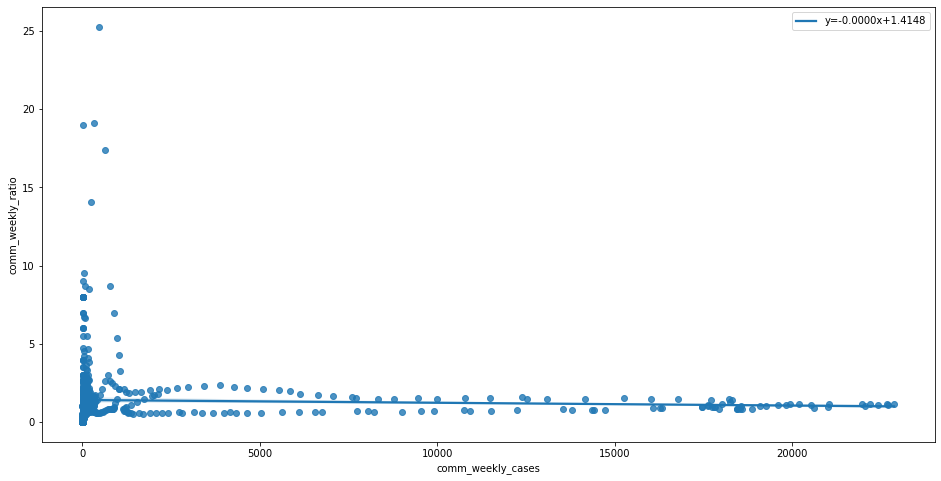

In [37]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df["comm_weekly_cases"],df["comm_weekly_ratio"])
fig, ax = plt.subplots(figsize=(16,8))
graph1 = sns.regplot(x="comm_weekly_cases", y="comm_weekly_ratio", data=df, ax=ax,
                 line_kws={'label':"y={0:.4f}x+{1:.4f}".format(slope,intercept)})
graph1.legend()

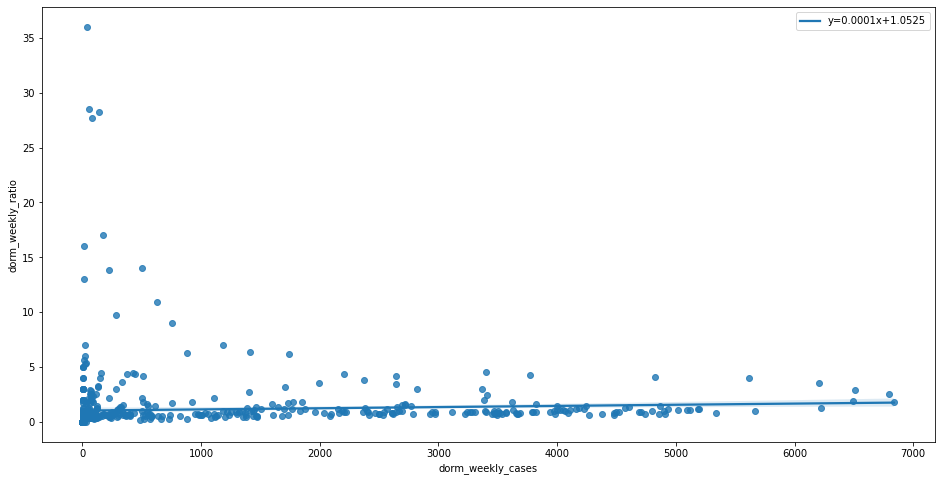

In [39]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df["dorm_weekly_cases"],df["dorm_weekly_ratio"])
fig, ax = plt.subplots(figsize=(16,8))
graph2 = sns.regplot(x="dorm_weekly_cases", y="dorm_weekly_ratio", data=df, ax=ax,
                 line_kws={'label':"y={0:.4f}x+{1:.4f}".format(slope,intercept)})
graph2.legend()

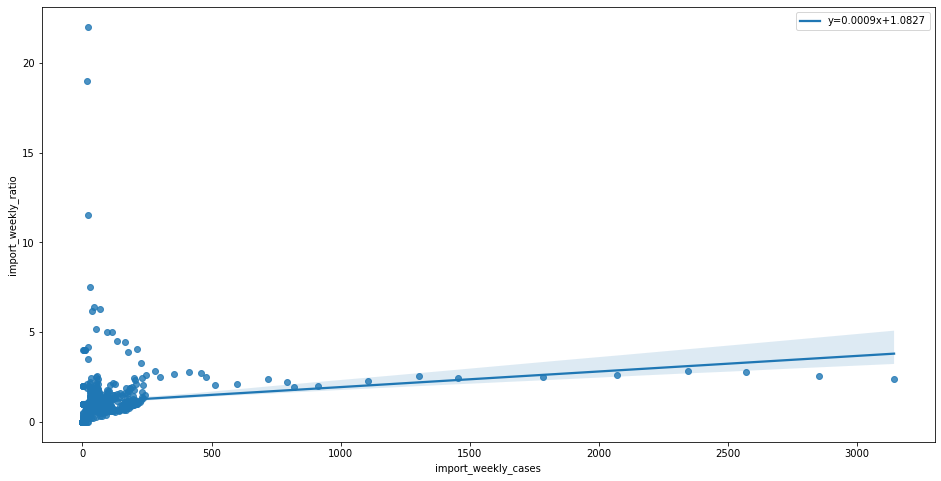

In [40]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df["import_weekly_cases"],df["import_weekly_ratio"])
fig, ax = plt.subplots(figsize=(16,8))
graph3 = sns.regplot(x="import_weekly_cases", y="import_weekly_ratio", data=df, ax=ax,
                 line_kws={'label':"y={0:.4f}x+{1:.4f}".format(slope,intercept)})
graph3.legend()

No observable relationship between weekly cases and weekly ratio

<AxesSubplot:ylabel='import_weekly_ratio'>

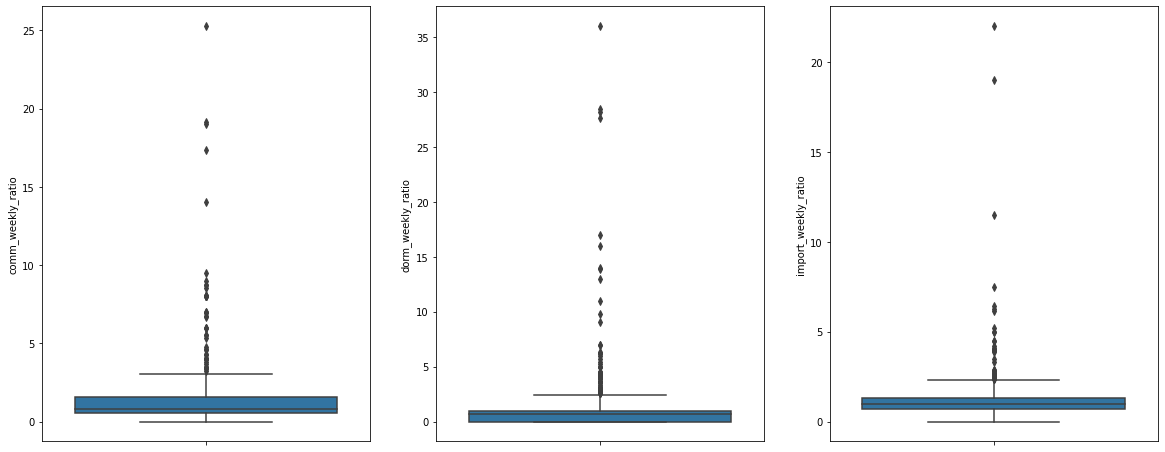

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,8))
sns.boxplot(data=df, y="comm_weekly_ratio", ax=axes[0])
sns.boxplot(data=df, y="dorm_weekly_ratio", ax=axes[1])
sns.boxplot(data=df, y="import_weekly_ratio", ax=axes[2])

Most weekly ratio are between 0 to 5.

### Checking for stationary of dataset
Dataset is considered stationary if p-value is less than or equal to 0.05.

If dataset is non-stationary, differencing will be perform on the dataset and stationary of differtiated data will
be check again.

In [259]:
from statsmodels.tsa.stattools import adfuller

In [262]:
def adfuller_test(data):
    result=adfuller(data)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Data has no unit root and is stationary and differencing is not needed")
    else:
        print("Time series has a unit root, indicating it is non-stationary")

In [263]:
adfuller_test(df["comm_weekly_ratio"])

ADF Test Statistic : -5.502206838053259
p-value : 2.0592190699544047e-06
#Lags Used : 16
Number of Observations Used : 687
Data has no unit root and is stationary and differencing is not needed


### ARIMA Parameters

Each component in ARIMA functions as a parameter with a standard notation. For ARIMA models, a standard notation would be ARIMA with p, d, and q, 3 parameters to fine-tune.

The parameters are defined as:

    p: the number of lag observations in the model; also known as the lag order.
    d: the number of times that the raw observations are differenced; also known as the degree of differencing.
    q: the size of the moving average window; also known as the order of the moving average.

In [203]:
df_arima = df[["date", "comm_weekly_ratio"]]

In [204]:
df_arima['date']=pd.to_datetime(df_arima["date"])
df_arima.set_index('date',inplace=True)

/tmp/ipykernel_98657/3307134559.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_arima['date']=pd.to_datetime(df_arima["date"])


<AxesSubplot:xlabel='date', ylabel='comm_weekly_ratio'>

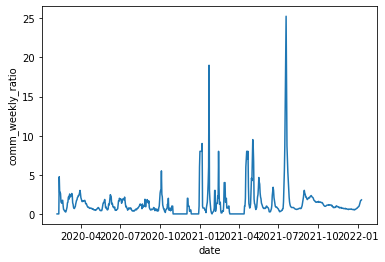

In [205]:
sns.lineplot(data=df_arima, x="date", y="comm_weekly_ratio")

In [206]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import DateOffset

/home/ken/git_repo/API_project/venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


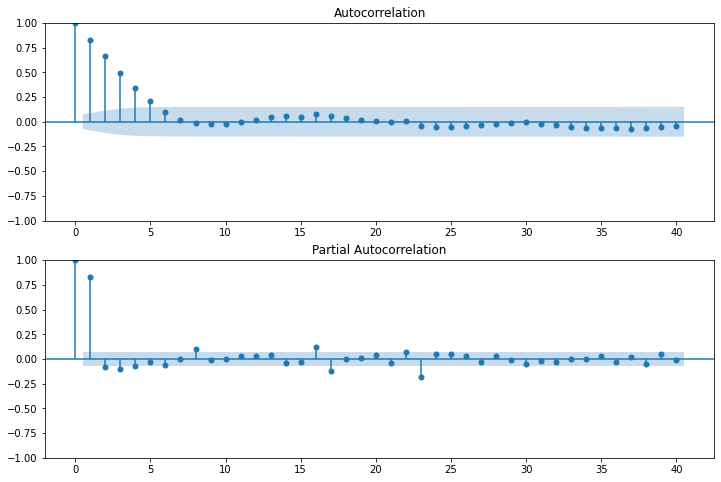

In [221]:
fig = plt.figure(figsize=(12,8))
# Decide the value for q, a suitable q will be the number of points beginning that is outside of the blue-shaded area
ax1 = fig.add_subplot(211)
fig = plot_acf(df_arima["comm_weekly_ratio"].iloc[1:],lags=40,ax=ax1)
# Decide the value for p, a suitable p will be the number of points beginning that is outside of the blue-shaded area
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_arima["comm_weekly_ratio"].iloc[1:],lags=40,ax=ax2)
# d = 0

In [277]:
# p was changed from 2 to 1 to ensure that all p-value is below 0.05.
model=ARIMA(df_arima["comm_weekly_ratio"],order=(1,0,6))
model_fit=model.fit()

/home/ken/git_repo/API_project/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/ken/git_repo/API_project/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/ken/git_repo/API_project/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [278]:
# As all p-value is <0.05, thus model is OK.
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      comm_weekly_ratio   No. Observations:                  704
Model:                 ARIMA(1, 0, 6)   Log Likelihood               -1100.690
Date:                Mon, 10 Jan 2022   AIC                           2219.380
Time:                        21:27:48   BIC                           2260.391
Sample:                    02-06-2020   HQIC                          2235.229
                         - 01-09-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3761      0.371      3.709      0.000       0.649       2.103
ar.L1          0.2902      0.124      2.340      0.019       0.047       0.533
ma.L1          0.5910      0.123      4.788      0.000       0.349       0.833
ma.L2          0.5284      0.119      4.440      0.000       0.295       0.762
ma.L3          0.4233      0.118      3.578      0.000       0.191       0.655
ma.L4          0.3063      0.092      3.321      0.001       0.126       0.487
ma.L5          0.2475      0.059      4.177      0.000       0.131       0.364
ma.L6          0.1539      0.047      3.242      0.001       0.061       0.247
sigma2         1.3327      0.019     71.808      0.000       1.296       1.369
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            121015.85
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               6.20   Skew:                             1.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        67.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/tmp/ipykernel_98657/3957946545.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_arima['forecast']=model_fit.predict(start=len(df_arima)-7,end=len(df_arima),dynamic=True)


<AxesSubplot:xlabel='date'>

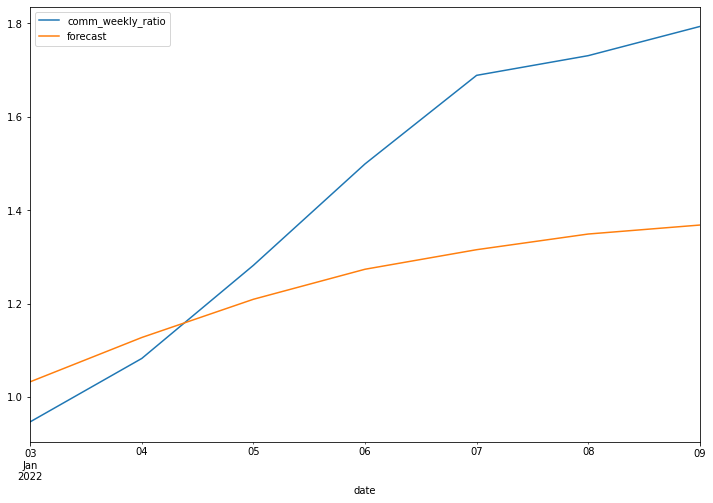

In [279]:
df_arima['forecast']=model_fit.predict(start=len(df_arima)-7,end=len(df_arima),dynamic=True)
df_arima[['comm_weekly_ratio','forecast']][-7:].plot(figsize=(12,8))

In [280]:
arima_error = mean_squared_error(df_arima.forecast[-7:],df_arima.comm_weekly_ratio[-7:])
error = pd.DataFrame(data=[arima_error], columns=["Arima Error mse"],index=None)

### Training time-series model using LSTM



In [284]:
#Variables for training
cols = list(df)[1:7]
df_for_training = df[cols].astype(float)

In [285]:
print(cols)

['comm_weekly_cases', 'comm_weekly_ratio', 'dorm_weekly_cases', 'dorm_weekly_ratio', 'import_weekly_cases', 'import_weekly_ratio']


In [170]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# Use StandardScaler() to scale the values
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [171]:
import pickle
pickle.dump(scaler, open('scaler.pkl','wb'))

In [172]:
# Initialize training data and target data
trainX = []
trainY = []

# Number of days we are predicting
n_future = 1   
# 14 days of data from all 6 features in cols is used to predict 1 day of all 6 features.
n_past = 14  

#Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i])

In [173]:
trainX, trainY = np.array(trainX), np.array(trainY)
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (690, 14, 6).
trainY shape == (690, 6).


In [174]:
# Define the Neural network model, LSTM is used.
# Model is regularized as model is highly volatile
model = Sequential()
model.add(LSTM(64, kernel_regularizer=l2(0.05), recurrent_regularizer=l2(0.05), bias_regularizer=l2(0.05), activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, kernel_regularizer=l2(0.05), recurrent_regularizer=l2(0.05), bias_regularizer=l2(0.05), activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
# Compile and view summary of model
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_37 (LSTM)              (None, 14, 64)            18176     
                                                                 
 lstm_38 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_17 (Dropout)        (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 6)                 198       
                                                                 
Total params: 30,790
Trainable params: 30,790
Non-trainable params: 0
_________________________________________________________________


Epoch 1/150
39/39 - 3s - loss: 12.1539 - val_loss: 10.8985 - 3s/epoch - 65ms/step
Epoch 2/150
39/39 - 0s - loss: 7.9698 - val_loss: 8.0546 - 276ms/epoch - 7ms/step
Epoch 3/150
39/39 - 0s - loss: 5.9492 - val_loss: 6.6172 - 271ms/epoch - 7ms/step
Epoch 4/150
39/39 - 0s - loss: 4.9008 - val_loss: 5.8214 - 271ms/epoch - 7ms/step
Epoch 5/150
39/39 - 0s - loss: 4.2725 - val_loss: 5.3344 - 277ms/epoch - 7ms/step
Epoch 6/150
39/39 - 0s - loss: 3.8485 - val_loss: 5.0309 - 285ms/epoch - 7ms/step
Epoch 7/150
39/39 - 0s - loss: 3.5299 - val_loss: 4.7094 - 286ms/epoch - 7ms/step
Epoch 8/150
39/39 - 0s - loss: 3.2459 - val_loss: 4.4567 - 281ms/epoch - 7ms/step
Epoch 9/150
39/39 - 0s - loss: 3.0129 - val_loss: 4.2882 - 295ms/epoch - 8ms/step
Epoch 10/150
39/39 - 0s - loss: 2.7908 - val_loss: 4.0382 - 296ms/epoch - 8ms/step
Epoch 11/150
39/39 - 0s - loss: 2.5957 - val_loss: 3.8370 - 281ms/epoch - 7ms/step
Epoch 12/150
39/39 - 0s - loss: 2.4073 - val_loss: 3.6665 - 282ms/epoch - 7ms/step
Epoch 13/150


Epoch 100/150
39/39 - 0s - loss: 0.5911 - val_loss: 1.9809 - 289ms/epoch - 7ms/step
Epoch 101/150
39/39 - 0s - loss: 0.5821 - val_loss: 2.0009 - 286ms/epoch - 7ms/step
Epoch 102/150
39/39 - 0s - loss: 0.5771 - val_loss: 1.9941 - 295ms/epoch - 8ms/step
Epoch 103/150
39/39 - 0s - loss: 0.6014 - val_loss: 1.9880 - 275ms/epoch - 7ms/step
Epoch 104/150
39/39 - 0s - loss: 0.5909 - val_loss: 1.9788 - 290ms/epoch - 7ms/step
Epoch 105/150
39/39 - 0s - loss: 0.5906 - val_loss: 1.9867 - 283ms/epoch - 7ms/step
Epoch 106/150
39/39 - 0s - loss: 0.5843 - val_loss: 1.9818 - 281ms/epoch - 7ms/step
Epoch 107/150
39/39 - 0s - loss: 0.5787 - val_loss: 1.9787 - 279ms/epoch - 7ms/step
Epoch 108/150
39/39 - 0s - loss: 0.5829 - val_loss: 1.9723 - 275ms/epoch - 7ms/step
Epoch 109/150
39/39 - 0s - loss: 0.5749 - val_loss: 1.9741 - 279ms/epoch - 7ms/step
Epoch 110/150
39/39 - 0s - loss: 0.5768 - val_loss: 1.9719 - 279ms/epoch - 7ms/step
Epoch 111/150
39/39 - 0s - loss: 0.5721 - val_loss: 1.9743 - 289ms/epoch - 7

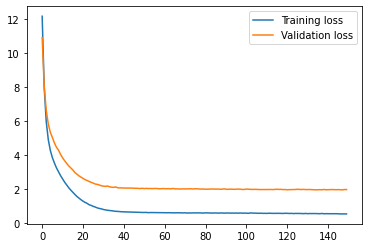

In [175]:
# fit the model
history = model.fit(trainX, trainY, epochs=150, batch_size=16, validation_split=0.1, verbose=2)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [177]:
# save model
model.save('covid_model')

INFO:tensorflow:Assets written to: covid_model/assets


INFO:tensorflow:Assets written to: covid_model/assets


In [182]:
# when the first date of predicted day start from
n_past = 7
# Number of days to be predicted
n_days_for_prediction=7
# List of dates that is predicted.
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction).tolist()

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) 
# transform scaled to non-scaled values
y_pred_future = scaler.inverse_transform(prediction)

[Timestamp('2022-01-03 00:00:00', freq='D'),
 Timestamp('2022-01-04 00:00:00', freq='D'),
 Timestamp('2022-01-05 00:00:00', freq='D'),
 Timestamp('2022-01-06 00:00:00', freq='D'),
 Timestamp('2022-01-07 00:00:00', freq='D'),
 Timestamp('2022-01-08 00:00:00', freq='D'),
 Timestamp('2022-01-09 00:00:00', freq='D')]

In [189]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

# Predicted data using LSTM model    
df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'comm_weekly_ratio':y_pred_future[:,1]})
df_forecast['date']=pd.to_datetime(df_forecast['date'])

# Original data
original = df[['date', 'comm_weekly_ratio']]
original['date']=pd.to_datetime(original['date'])
original = original.loc[original['date'] >= '2022-01-03']

/tmp/ipykernel_98657/2797934760.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['date']=pd.to_datetime(original['date'])


/home/ken/git_repo/API_project/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ken/git_repo/API_project/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Covid community Weekly ratio: Original(Blue) & Forecast(Orange)'}, xlabel='date', ylabel='comm_weekly_ratio'>

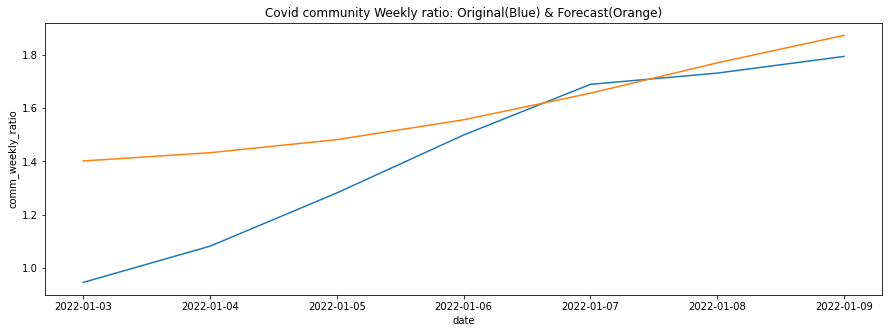

In [190]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title('Covid community Weekly ratio: Original(Blue) & Forecast(Orange)')
# original is blue
sns.lineplot(original['date'], original['comm_weekly_ratio'],ax=ax)
# Forcast is orange
sns.lineplot(df_forecast['date'], df_forecast['comm_weekly_ratio'], ax=ax)

In [281]:
LSTM_error = mean_squared_error(original['comm_weekly_ratio'],df_forecast['comm_weekly_ratio'])
error["LSTM Error mse"]=[LSTM_error]

In [282]:
error

,Arima Error mse,LSTM Error mse
0,0.076014,0.054563
